In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!chmod 600 /content/kaggle.json

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

 94% 169M/179M [00:01<00:00, 129MB/s]
100% 179M/179M [00:01<00:00, 130MB/s]


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
import zipfile

In [6]:
zip_source = '/content/tomatoleaf.zip'
extract_destination = '/content/dataset/tomato'

with zipfile.ZipFile(zip_source, 'r') as zip_ref:
  zip_ref.extractall(extract_destination)
  zip_ref.close()

In [7]:
train_dir = '/content/dataset/tomato/tomato/train'
val_dir = '/content/dataset/tomato/tomato/val'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=128,
    shuffle=True,
    class_mode='categorical'
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_loss') < 0.1) and (logs.get('val_accuracy') > 0.94):
      print("accuracy > 94")
      self.model.stop_training = True

callbacks = myCallback()

In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [15]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-4),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               2097280   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                      

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=8,
    callbacks=[callbacks]
)

Epoch 1/20
32/32 [==============================] - 35s 993ms/step - loss: 1.7338 - accuracy: 0.4150 - val_loss: 1.3882 - val_accuracy: 0.5370
Epoch 2/20
32/32 [==============================] - 31s 986ms/step - loss: 1.0188 - accuracy: 0.6591 - val_loss: 1.0958 - val_accuracy: 0.6490
Epoch 3/20
32/32 [==============================] - 30s 956ms/step - loss: 0.7638 - accuracy: 0.7407 - val_loss: 0.8553 - val_accuracy: 0.7270
Epoch 4/20
32/32 [==============================] - 29s 899ms/step - loss: 0.6440 - accuracy: 0.7887 - val_loss: 0.7109 - val_accuracy: 0.7550
Epoch 5/20
32/32 [==============================] - 29s 913ms/step - loss: 0.5969 - accuracy: 0.8047 - val_loss: 0.7609 - val_accuracy: 0.7510
Epoch 6/20
32/32 [==============================] - 30s 934ms/step - loss: 0.5144 - accuracy: 0.8276 - val_loss: 0.6779 - val_accuracy: 0.7690
Epoch 7/20
32/32 [==============================] - 29s 923ms/step - loss: 0.4343 - accuracy: 0.8584 - val_loss: 0.5893 - val_accuracy: 0.7970

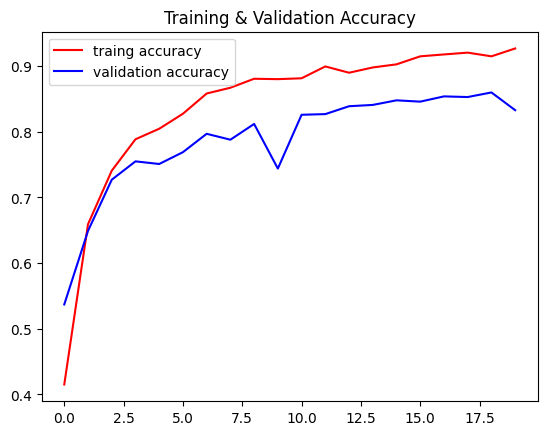

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='traing accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training & Validation Accuracy')
plt.legend(loc='best')
plt.figure()
plt.show()

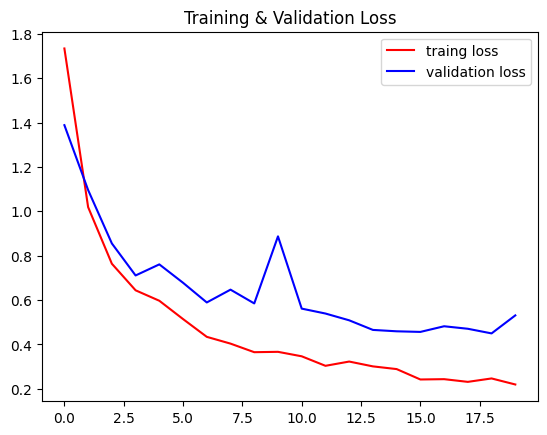

<Figure size 640x480 with 0 Axes>

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='traing loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training & Validation Loss')
plt.legend(loc='best')
plt.figure()
plt.show()

In [21]:
model.save("model_tomato.h5")